# Geography Analysis

## Instructions
1. Fill in the dataset in section 1.1

2. Run all cells

3. Review the summary pdf generated AND/OR explore each metric below.
    - All metrics are identified by a short keyword, and consist of a "Setup" and "Analyses" portion. The "Setup" portion contains code that does not need to be modified unless customization is needed, and the "Analyses" portion provides an interactive display of the results.

## Table of Contents
1. [Initial Setup](#setup) <br/>
    1.1 [Dataset](#dataset)
2. geo_ctr Metric: [Country Counts](#geo_ctr)<br/>
    2.1 [Setup](#geo_ctr_setup)<br/>
    2.2 [Analyses](#geo_ctr_analyses)
3. geo_tag Metric: [Image Tags](#geo_tag)<br/>
    3.1 [Setup](#geo_tag_setup)<br/>
    3.2 [Analyses](#geo_tag_analyses)
4. geo_lng Metric: [Languages for tourist vs local](#geo_lng) <br/>
    4.1 [Setup](#geo_lng_setup)<br/>
    4.2 [Analyses](#geo_lng_analyses)
5. [Setting up summary pdf](#summarypdf)

# Initial Setup 
<a id="setup"></a>

In [1]:
from __future__ import print_function
import argparse
import os
try: # only change dir if necessary
    import datasets
except ModuleNotFoundError:
    os.chdir(os.pardir)
    import datasets
import pickle
import itertools
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from scipy import stats
import PIL.Image
from scipy.cluster.hierarchy import dendrogram, linkage
from math import sqrt
import cv2
import matplotlib.patches as patches
from scipy.spatial.distance import squareform
import pycountry
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
try: 
    from mpl_toolkits.basemap import Basemap
except (FileNotFoundError, ModuleNotFoundError) as e: 
    print(e, '\n', 'Please refer to \'Potential Environment Issues\' on the README page to resolve. ')
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
try: 
    from countryinfo import CountryInfo
except (FileNotFoundError, ModuleNotFoundError) as e: 
    print(e, '\n', 'Please refer to \'Potential Environment Issues\' on the README page to resolve. ')
from sklearn.model_selection import permutation_test_score
import re
import copy
import textwrap
import matplotlib.patches as mpatches
import operator
from matplotlib.font_manager import FontProperties
import imageio
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Layout
import ipywidgets as widgets
from IPython.core.display import HTML
from IPython.display import display, HTML, Image
import time
import warnings
import random
import pandas as pd
import folium 

[Errno 2] No such file or directory: '/Users/home/miniconda3/envs/toolenv/share/proj/epsg' 
 Please refer to 'Potential Environment Issues' on the README page to resolve. 


In [2]:
%matplotlib inline

In [3]:
COLORS = sns.color_palette('Set2', 2)
SAME_EXTENT = (-0.5, 6.5, -0.5, 6.5)
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore")

if not os.path.exists("dataloader_files"):
    os.mkdir("dataloader_files")
if not os.path.exists("results"):
    os.mkdir("results")
if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")

In [4]:
# https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
def hide_toggle(for_next=False, toggle_text='Toggle show/hide'):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [5]:
hide_toggle(for_next=True, toggle_text='Show/hide helper functions')

In [6]:
def folder(num, folder):
    if not os.path.exists("results/{0}/{1}".format(folder, num)):
        os.mkdir("results/{0}/{1}".format(folder, num))
    file = open("results/{0}/{1}/results.txt".format(folder, num), "w")
    return file

# Projecting a set of features into a lower-dimensional subspace with PCA
def project(features, dim):
    standardized = StandardScaler().fit_transform(features)
    pca = PCA(n_components=dim)
    principalComponents = pca.fit_transform(X=standardized)
    return principalComponents

# Calculating the binomial proportion confidence interval
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

def country_to_iso3(country):
    missing = {'South+Korea': 'KOR',
            'North+Korea': 'PRK',
            'Laos': 'LAO',
            'Caribbean+Netherlands': 'BES',
            'St.+Lucia': 'LCA',
            'East+Timor': 'TLS',
            'Democratic+Republic+of+Congo': 'COD',
            'Swaziland': 'SWZ',
            'Cape+Verde': 'CPV',
            'C%C3%B4te+d%C2%B4Ivoire': 'CIV',
            'Ivory+Coast': 'CIV',
            'Channel+Islands': 'GBR'
            }
    try:
        iso3 = pycountry.countries.search_fuzzy(country.replace('+', ' '))[0].alpha_3
    except LookupError:
        try:
            iso3 = missing[country]
        except KeyError:
            iso3 = None
    return iso3

def display_filepaths(filepaths, width=100, height=100):
    sidebyside = widgets.HBox([widgets.Image(value=open(filepath, 'rb').read(), format='png', width=width, height=height) for filepath in filepaths], layout=Layout(height='{}px'.format(height)))
    display(sidebyside)

## Dataset
Fill in below with dataset and file path names
<a id="dataset"></a>

In [7]:
transform_train = transforms.Compose([ 
        transforms.ToTensor()
        ])
# dataset = datasets.YfccPlacesDataset(transform_train)
# folder_name = 'yfcc_supp'

dataset = datasets.CityScapesDataset(transform_train)
folder_name = 'cityscapes_test'

done with ids (1/2)
done with categories (2/2)


In [8]:
save_loc = '1_pager_geo'
os.system("rm -r results/{0}/{1}".format(folder_name, save_loc))
file = folder(save_loc, folder_name)
first_pass = True
to_write = {}
if not os.path.exists("checkpoints/{}".format(folder_name)):
    os.mkdir("checkpoints/{}".format(folder_name))

# geo_ctr Metric: Country Counts
<a id="geo_ctr"></a>

## Setup
<a id="geo_ctr_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide geo_ctr code')

In [40]:
counts_gps = pickle.load(open("results/{}/geo_tag_gps.pkl".format(folder_name), "rb"))
counts_gps.keys()

dict_keys(['region_tags'])

In [41]:
len(counts_gps['region_tags']['Bremen'])
len(dataset.categories)

42

In [42]:
test = counts_gps['region_tags']['Bremen']
test_dict = {}
for i in range(len(test)):
    test_dict[dataset.categories[i]] = test[i]

In [43]:
np.sum(test)

23561.0

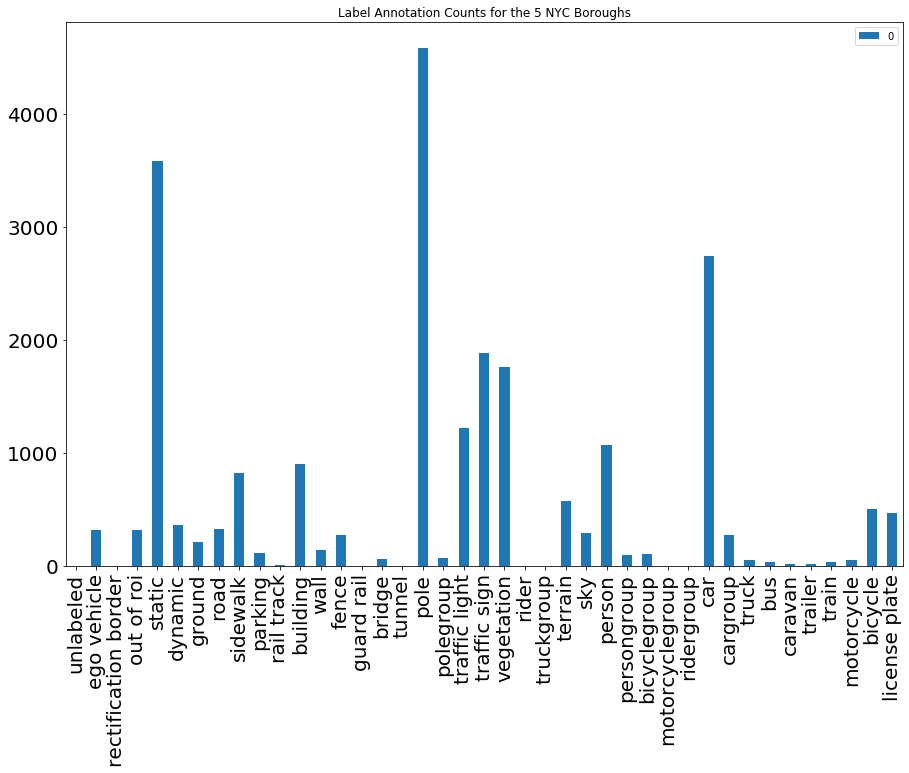

In [44]:
df = pd.DataFrame.from_dict(test_dict, orient='index')
df.plot(kind = 'bar', figsize=(15,10), title = "Label Annotation Counts for the 5 NYC Boroughs", fontsize = 20, legend = 'reverse')


In [34]:
counts = pickle.load(open("results/{}/geo_ctr_gps.pkl".format(folder_name), "rb"))
counts.keys()

dict_keys(['region_to_id', 'region_to_cat', 'region_tags', 'id_to_gps', 'id_to_region'])

In [39]:
len((counts['region_to_cat']['Bremen']).keys())

37

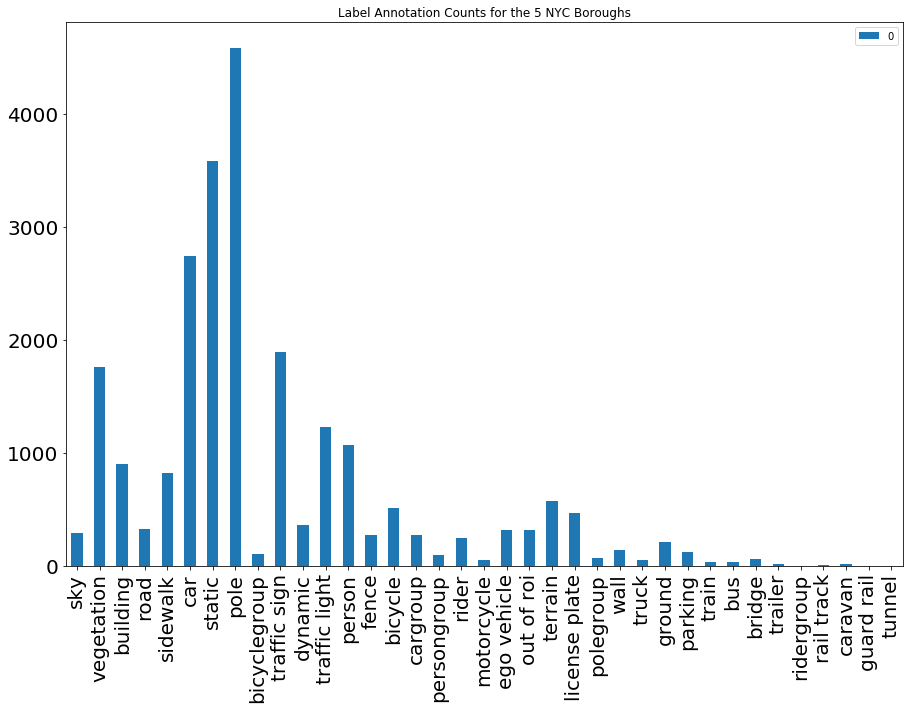

In [24]:
df = pd.DataFrame.from_dict(test_dict_1, orient='index')
df.plot(kind = 'bar', figsize=(15,10), title = "Label Annotation Counts for the 5 NYC Boroughs", fontsize = 20, legend = 'reverse')


In [33]:
test_dict_1 = counts['region_to_cat']['Bremen']
running = 0
for key in test_dict_1:
    running += test_dict_1[key]
print(running)

23561


In [ ]:
# check if we use country counts method or not:
is_country_counts = os.path.exists("results/{}/geo_ctr.pkl".format(folder_name))

if is_country_counts: 
    counts = pickle.load(open("results/{}/geo_ctr.pkl".format(folder_name), "rb"))
    iso3_to_subregion = pickle.load(open('util_files/iso3_to_subregion_mappings.pkl', 'rb'))
    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

    # https://ramiro.org/notebook/basemap-choropleth/
    cm = plt.get_cmap('Blues')
    bins = np.logspace(min(list(counts.values())), np.log2(max(list(counts.values()))+1), base=2.0)
    num_colors = len(bins)
    scheme = [cm(i / num_colors) for i in range(num_colors)]

    subregion_counts = {}
    iso3_to_bin = {}
    total = sum(counts.values())
    country_count_phrases = []
    iso3_to_scaledpop = {}

    for country in ['England', 'Scotland', 'Wales', 'Northern+Ireland']:
        if country in counts.keys():
            counts['United+Kingdom'] += counts[country]
        counts.pop(country, None)

    for country, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
        country_count_phrases.append("{0}: {1}   {2}%".format(country, count, round(100.*count/total)))
        iso3 = country_to_iso3(country)
        if iso3 is not None:
            iso3_to_bin[iso3] = np.digitize(count, bins)
            try:
                iso3_to_scaledpop[iso3] = count / CountryInfo(country.replace('+', ' ')).population()
            except KeyError:
                pass
    #             print("{} not found in CountryInfo".format(country))
        try:
            subregion = iso3_to_subregion[iso3]
            if subregion in subregion_counts.keys():
                subregion_counts[subregion] += count
            else:
                subregion_counts[subregion] = count
        except KeyError:
            print("This country's subregion not found: {}".format(country))
    for key in iso3_to_scaledpop.keys():
        iso3_to_scaledpop[key] /= min(iso3_to_scaledpop.values())


else:
    counts_gps = pickle.load(open("results/{}/geo_ctr_gps.pkl".format(folder_name), "rb"))
    region_to_id = counts_gps["region_to_id"]
    id_to_gps = counts_gps["id_to_gps"]

#     region_to_id = pickle.load(open("results/{}/region_to_id.pkl".format(folder_name), "rb"))
#     id_to_gps = pickle.load(open("results/{}/id_to_gps.pkl".format(folder_name), "rb"))

    geo_boundaries = dataset.geo_boundaries

    choro_data = pd.read_csv(dataset.choropleth_filepath)

    colors = [
        'red',
        'blue',
        'gray',
        'darkred',
        'beige',
        'green',
        'purple',
        'pink',
        'green',
        'purple',
        'pink',
    ]
    subregion_counts = {}
    for key in region_to_id:
        filename_arr = region_to_id[key]
        subregion_counts[key] = len(filename_arr)

def country_counts_num(topn):
    if is_country_counts:
        print("Total images: {}\n".format(total))
        print("Country Counts\n")

        print("Top:\n")
        for i in range(topn):
            print(country_count_phrases[i])

        print("\nBottom:\n")
        for i in range(topn):
            print(country_count_phrases[-1-i])
    else:
        print("no country counts information available")

def subregion_counts_num():
    print("Subregion Counts\n")
    
        
    total_subregion = sum(subregion_counts.values())
    for subregion, count in sorted(subregion_counts.items(), key=lambda x: x[1], reverse=True):
        print("{0}: {1}    {2}%".format(subregion, count, round(100.*count/total_subregion)))


def region_map():
    if is_country_counts:
        fig = plt.figure(figsize=(16, 7))

        fontsize = 20
        ax = fig.add_subplot(111, facecolor='w', frame_on=False)
        fig.suptitle('Dataset representation by number of images', fontsize=fontsize, y=.95)

        m = Basemap(lon_0=0, projection='robin')
        m.drawmapboundary(color='w')

        shapefile = 'util_files/ne_10m_admin_0_countries_lakes'

        m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
        for info, shape in zip(m.units_info, m.units):
            iso3 = info['ADM0_A3']
            if iso3 not in iso3_to_bin.keys():
                color = '#dddddd'
            else:
                try:
                    color = scheme[iso3_to_bin[iso3]]
                except IndexError:
                    print(iso3)
                    print("this index: {0} when length is {1}".format(iso3_to_bin[iso3], len(scheme)))


            patches = [Polygon(np.array(shape), True)]
            pc = PatchCollection(patches)
            pc.set_facecolor(color)
            ax.add_collection(pc)

        # Cover up Antarctica so legend can be placed over it.
        ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

        # Draw color legend.
        ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
        cmap = mpl.colors.ListedColormap(scheme)
        cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
        #cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='vertical')
        spots = len(bins) // 4
        spots = [0, spots, spots*2, spots*3, len(bins)- 1]
        cb.ax.set_xticklabels([str(round(int(i), -3)) if j in spots else '' for j, i in enumerate(bins)])
        cb.ax.tick_params(labelsize=fontsize)
        plt.show()

        print("Total countries: {}".format(len(iso3_to_bin)))
    else:
        m = folium.Map()
        folium.GeoJson(geo_boundaries, name="geojson").add_to(m)
        count = 0
        for key in region_to_id:
            filename_arr = region_to_id[key]
            for i, fileid in enumerate(filename_arr):
                if i > 5:
                    break
                # get lon lat
                folium.Marker(
                    location=[id_to_gps[fileid]['lat'], id_to_gps[fileid]['lng']], 
                    popup=folium.Popup(max_width=100),
                    icon=folium.Icon(color=colors[count])
                ).add_to(m)
            count += 1
        return m

def choropleth():
    if not is_country_counts:
        m = folium.Map()

        folium.Choropleth(
            geo_data=geo_boundaries,
            name="choropleth",
            data=choro_data,
            columns=["Region", "Data"],
            key_on="feature.properties.name_1",
            fill_color="BuPu",
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name="My Data",
        ).add_to(m)

        folium.LayerControl().add_to(m)

        count = 0
        for key in region_to_id:
            filename_arr = region_to_id[key]
            for i, fileid in enumerate(filename_arr):
                if i > 5:
                    break
                # get lon lat
                folium.Marker(
                    location=[id_to_gps[fileid]['lat'], id_to_gps[fileid]['lng']], 
                    popup=folium.Popup(max_width=100),
                    icon=folium.Icon(color=colors[count])
                ).add_to(m)
            count += 1
        return m
    else:
        print("No custom subregion data available")
def country_map_population():
    if is_country_counts:
        fig = plt.figure(figsize=(16, 7))

        fontsize = 20
        ax = fig.add_subplot(111, facecolor='w', frame_on=False)

        m = Basemap(lon_0=0, projection='robin')
        m.drawmapboundary(color='w')

        shapefile = 'util_files/ne_10m_admin_0_countries_lakes'

        cm = plt.get_cmap('Blues')
        bins = np.logspace(min(list(iso3_to_scaledpop.values())), np.log2(max(list(iso3_to_scaledpop.values()))+1.), base=2.0)
        num_colors = len(bins)
        scheme = [cm(i / num_colors) for i in range(num_colors)]

        m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
        for info, shape in zip(m.units_info, m.units):
            iso3 = info['ADM0_A3']
            if iso3 not in iso3_to_scaledpop.keys():
                color = '#dddddd'
            else:
                try:
                    color = scheme[np.digitize(iso3_to_scaledpop[iso3], bins)]
                except IndexError:
                    print(iso3)
                    print("this index: {0} when length is {1}".format(iso3_to_bin[iso3], len(scheme)))


            patches = [Polygon(np.array(shape), True)]
            pc = PatchCollection(patches)
            pc.set_facecolor(color)
            ax.add_collection(pc)

        ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

        to_write[0] = ['(geo_ctr) Geographic representation of dataset scaled by country population, colored on a logarithmic scale.']
        plt.savefig("results/{0}/{1}/0.png".format(folder_name, save_loc), bbox_inches='tight', pad_inches=.2)
        fig.suptitle('Dataset representation scaled by country population, logarithmic scale', fontsize=fontsize, y=.95)
        plt.show()
    else:
        print("No country information available")

## Analyses
<a id="geo_ctr_analyses"></a>

Counts by country

In [ ]:
interact(country_counts_num, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

Counts by subregion

In [ ]:
subregion_counts_num()

Visualization of representation by country

In [ ]:
region_map()

Visualization of representation by country, scaled by population. Logarithmic scale. Some countries may be grayed out because the population could not be found for that country.

In [ ]:
country_map_population()

Choropleth visualization with custom data input

In [ ]:
choropleth()

# geo_tag Metric: Image Tags
<a id="geo_tag"></a>

## Setup 
<a id="geo_tag_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide geo_tag code')

In [ ]:
if not os.path.exists("results/{0}/6".format(folder_name)):
    os.mkdir("results/{0}/6".format(folder_name))
info_stats = pickle.load(open("results/{}/geo_tag.pkl".format(folder_name), "rb")) #20GB
country_tags = info_stats['country_tags']
tag_to_subregion_features = info_stats['tag_to_subregion_features']
iso3_to_subregion = pickle.load(open('util_files/iso3_to_subregion_mappings.pkl', 'rb'))
categories = dataset.categories
total_counts = np.zeros(len(categories))
subregion_tags = {}
for country, counts in country_tags.items():
    total_counts = np.add(total_counts, counts)
    subregion = iso3_to_subregion[country_to_iso3(country)]
    if subregion not in subregion_tags.keys():
        subregion_tags[subregion] = np.zeros(len(categories))
    subregion_tags[subregion] = np.add(subregion_tags[subregion], counts)
total_counts = total_counts.astype(int)
sum_total_counts = int(np.sum(total_counts))
if not os.path.exists('checkpoints/{}/6_a.pkl'.format(folder_name)):
    pvalues_over = {} # pvalue : '[country]: [tag] (country num and total num info for now)'
    pvalues_under = {} 
    for country, counts in country_tags.items():
        tags_for_country = int(np.sum(counts))
        if tags_for_country < 50: # threshold for country to have at least 50 tags so there are enough samples for analysis
            continue
        for i, count in enumerate(counts):
            this_counts = np.zeros(tags_for_country)
            this_counts[:int(count)] = 1
            that_counts = np.zeros(sum_total_counts - tags_for_country)
            that_counts[:total_counts[i] - int(count)] = 1
            p = stats.ttest_ind(this_counts, that_counts)[1]
            tag_info = '{0}-{1} ({2}/{3} vs {4}/{5})'.format(country, categories[i], int(count), tags_for_country, int(total_counts[i] - count), sum_total_counts - tags_for_country)
            if np.mean(this_counts) > np.mean(that_counts):
                pvalues_over[p] = tag_info
            else:
                pvalues_under[p] = tag_info
else:
    pvalues_under, pvalues_over = pickle.load(open('checkpoints/{}/6_a.pkl'.format(folder_name), 'rb'))
subregion_pvalues_over = {}
subregion_pvalues_under = {}
for subregion, counts in subregion_tags.items():
    tags_for_subregion = int(np.sum(counts))
    for i, count in enumerate(counts):
        this_counts = np.zeros(tags_for_subregion)
        this_counts[:int(count)] = 1
        that_counts = np.zeros(sum_total_counts - tags_for_subregion)
        that_counts[:total_counts[i] - int(count)] = 1
        p = stats.ttest_ind(this_counts, that_counts)[1]
        tag_info = '{0}-{1} ({2}/{3} vs {4}/{5})'.format(subregion, categories[i], int(count), tags_for_subregion, int(total_counts[i] - count), sum_total_counts - tags_for_subregion)
        if np.mean(this_counts) > np.mean(that_counts):
            subregion_pvalues_over[p] = tag_info
        else:
            subregion_pvalues_under[p] = tag_info

def tag_rep_by_country(topn):
    if first_pass:
        to_write[1] = ["(geo_tag) Overrepresentations of tags by country (tag in country vs tag in rest of the countries):"]
        for p, content in sorted(pvalues_over.items(), key=lambda x: x[0])[:4]:
            to_write[1].append(('{0}: {1}'.format(round(p, 4), content)))
        to_write[1].append("")
        to_write[1].append("Underrepresentations of tags by country (tag in country vs tag in rest of the countries):")
        for p, content in sorted(pvalues_under.items(), key=lambda x: x[0])[:4]:
            to_write[1].append(('{0}: {1}'.format(round(p, 4), content)))
        
    print("By Country\n")
    print('Over represented\n')
    for p, content in sorted(pvalues_over.items(), key=lambda x: x[0])[:topn]:
        print('{0}: {1}'.format(round(p, 4), content))
    print('\nUnder represented\n')
    for p, content in sorted(pvalues_under.items(), key=lambda x: x[0])[:topn]:
        print('{0}: {1}'.format(round(p, 4), content))

def tag_rep_by_subregion(topn):
    print("By Subregion\n")
    print('Over represented\n')
    for p, content in sorted(subregion_pvalues_over.items(), key=lambda x: x[0])[:topn]:
       print('{0}: {1}'.format(round(p, 4), content))
    print('\nUnder represented\n')
    for p, content in sorted(subregion_pvalues_under.items(), key=lambda x: x[0])[:topn]:
       print('{0}: {1}'.format(round(p, 4), content))

import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('checkpoints/{}/6_b.pkl'.format(folder_name)):
    phrase_to_value = {}
    # Look at appearance differences in how a tag is represented across subregions
    for tag in tag_to_subregion_features.keys():
        subregion_features = tag_to_subregion_features[tag]
        all_subregions = list(subregion_features.keys())
        all_features = []
        all_filepaths = []
        start = 0
        for subregion in all_subregions:
            this_features = [features[0] for features in subregion_features[subregion]]
            this_filepaths = [features[1] for features in subregion_features[subregion]]
            if len(this_features) > 0:
                all_features.append(np.array(this_features)[:, 0, :])
                all_filepaths.append(this_filepaths)
        if len(all_features) == 0:
            continue
        all_features = np.concatenate(all_features, axis=0)
        all_filepaths = np.concatenate(all_filepaths, axis=0)
        labels = np.zeros(len(all_features))
        for j, subregion in enumerate(all_subregions):
            labels[start:len(subregion_features[subregion])+start] = j
            start += len(subregion_features[subregion])
        num_features = int(np.sqrt(len(all_features)))
        all_features = StandardScaler().fit_transform(project(all_features, num_features))

        clf = svm.SVC(kernel='linear', probability=True, decision_function_shape='ovr', class_weight='balanced', max_iter=5000)

        if len(np.unique(labels)) <= 1:
            continue
        clf.fit(all_features, labels)
        acc = clf.score(all_features, labels)
        probs = clf.decision_function(all_features)

        labels = labels.astype(np.integer)
        plot_kwds = {'alpha' : .8, 's' : 30, 'linewidths':0}
        colorz = sns.color_palette('hls', int(np.amax(labels)) + 1)
        projection_instances = TSNE().fit_transform(all_features)
        plt.scatter(*projection_instances.T, **plot_kwds, c=[colorz[labels[i]] for i in range(len(all_features))])
        handles = []
        for lab in np.unique(labels):
            patch = mpatches.Patch(color=colorz[lab], label=all_subregions[lab])
            handles.append(patch)
        fontP = FontProperties()
        fontP.set_size('small')
        lgd = plt.legend(handles=handles, bbox_to_anchor=(1.04,1), loc="upper left", prop=fontP)
        plt.savefig('results/{0}/{1}/{2}_tsne.png'.format(folder_name, 6, dataset.categories[tag]), bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.close()

        class_preds = clf.predict(all_features)
        class_probs = clf.predict_proba(all_features)
        j_to_acc = {}
        for j, subregion in enumerate(all_subregions):
            if j in labels:
                # to get acc in subregion vs out
                this_labels = np.copy(labels)
                this_labels[np.where(labels!=j)[0]] = -1
                this_preds = np.copy(class_preds)
                this_preds[np.where(class_preds!=j)[0]] = -1
                this_acc = np.mean(this_preds == this_labels)
                j_to_acc[j] = this_acc

        fig = plt.figure(figsize=(16, 12))
        plt.subplots_adjust(hspace=.48)
        fontsize = 24
        diff_subregion = max(j_to_acc.items(), key=operator.itemgetter(1))[0]
        subregion_index = list(clf.classes_).index(diff_subregion)
        class_probs = class_probs[:, subregion_index]
        in_sub = np.where(labels == diff_subregion)[0]
        out_sub = np.where(labels != diff_subregion)[0]
        in_probs = class_probs[in_sub]
        out_probs = class_probs[out_sub]
        in_indices = np.argsort(in_probs)
        out_indices = np.argsort(out_probs)
        
        original_labels = np.copy(labels)

        def subregion_scoring(estimator, X_test, y_test):
            y_pred = estimator.predict(X_test)
            y_test[np.where(y_test!=diff_subregion)[0]] = -1
            y_pred[np.where(y_pred!=diff_subregion)[0]] = -1
            acc_random = np.mean(y_test == y_pred)
            return acc_random

        base_acc, rand_acc, p_value = permutation_test_score(clf, all_features, labels, scoring=subregion_scoring, n_permutations=100)
        value = base_acc/np.mean(rand_acc)
        if p_value > .05 and value < 1.2: # can tune as desired
            continue

        phrase = dataset.labels_to_names[dataset.categories[tag]]
        phrase_to_value[phrase] = [value, all_subregions[diff_subregion], acc, p_value, num_features, j_to_acc]
        
        pickle.dump([original_labels, class_probs, class_preds, diff_subregion, all_filepaths], open('results/{0}/{1}/{2}_info.pkl'.format(folder_name, 6, dataset.labels_to_names[dataset.categories[tag]]), 'wb'))
    pickle.dump(phrase_to_value, open('checkpoints/{}/6_b.pkl'.format(folder_name), 'wb'))
else:
    phrase_to_value = pickle.load(open('checkpoints/{}/6_b.pkl'.format(folder_name), 'rb'))

svm_options = []
best_tag = None
best_tag_value = 1.2
for phrase, value in sorted(phrase_to_value.items(), key=lambda x: x[1][0], reverse=True):
    value, region, acc, p_value, num_features, j_to_acc = phrase_to_value[phrase]
    if acc > .75 and value > best_tag_value:
        best_tag_value = value
        best_tag = phrase
    svm_options.append(('{0} in {1}: {2}% and {3}x'.format(phrase, region, round(100.*acc, 3), round(value, 3)), phrase))

def show_svm_tag(tag, num):
    if tag is None:
        return
    this_info = pickle.load(open('results/{0}/{1}/{2}_info.pkl'.format(folder_name, 6, tag), 'rb'))
    labels, class_probs, class_preds, diff_subregion, all_filepaths = this_info
    value, region, acc, p_value, num_features, j_to_acc = phrase_to_value[tag]
    if num is not None:
        print("{0} in {1} has acc: {2}, with p={3}, {4}x and {5} features".format(tag, region, round(acc, 3), round(p_value, 3), round(value, 3), num_features))
        print()
    
    in_sub = np.where(labels == diff_subregion)[0]
    out_sub = np.where(labels != diff_subregion)[0]
    in_probs = class_probs[in_sub]
    out_probs = class_probs[out_sub]
    in_indices = np.argsort(in_probs)
    out_indices = np.argsort(out_probs)
    
    to_save = False
    if num is None:
        to_write[2] = ['(geo_tag) To discern if there is an appearance difference in how certain subregions represent a tag, we extract scene-level features from each image, and fit a linear SVM to distinguish between the tag in the subregion and out of the subregion.\nAn example of the most linearly separable tag: {0} has an accuracy of {1} when classifying in {2} vs outside {2}.\n'.format(tag, round(acc, 3), region)]
        to_save = True
        num = 5
                
    def display_chunk(in_subregion_label=True, in_subregion_pred=True, to_save=False, name=None):
        subregion_filepaths = []
        if in_subregion_label == in_subregion_pred:
            counter = 0
        else:
            counter = -1
        while len(subregion_filepaths) < num:
            try:
                if in_subregion_label:
                    index_a = in_sub[in_indices[counter]]
                else:
                    index_a = out_sub[out_indices[counter]]
            except:
                break
            file_path_a = all_filepaths[index_a]
            if (in_subregion_pred and class_preds[index_a] == diff_subregion) or ((not in_subregion_pred) and class_preds[index_a] != diff_subregion):
                subregion_filepaths.append(file_path_a)
            if in_subregion_label == in_subregion_pred:
                counter += 1
            else:
                counter += -1
        if to_save and first_pass:
            this_loc = "results/{0}/{1}/1_{2}.png".format(folder_name, save_loc, name)
            if len(subregion_filepaths) > 0:
                fig = plt.figure(figsize=(16, 8))
                for i in range(num):
                    ax = fig.add_subplot(1, num, i+1)
                    ax.axis("off")
                    if i >= len(subregion_filepaths):
                        image = np.ones((3, 3, 3))
                    else:
                        image, _ = dataset.from_path(subregion_filepaths[i])
                        image = image.data.cpu().numpy().transpose(1, 2, 0)
                    im = ax.imshow(image, extent=SAME_EXTENT)
                plt.tight_layout()
                plt.savefig(this_loc, bbox_inches='tight')
                plt.close()
            else:
                os.system("cp util_files/no_images.png {0}".format(this_loc))
        elif len(subregion_filepaths) > 0:
            display_filepaths(subregion_filepaths, width = 800//len(subregion_filepaths), height=800//len(subregion_filepaths))
        else:
            print("No images in this category")
    if not to_save:
        print("In: Correct")
    else:
        to_write[2].append("In: Correct")
    display_chunk(True, True, to_save, 'a')
    if not to_save:
        print("In: Incorrect")
    else:
        to_write[2].append("In: Incorrect")
    display_chunk(True, False, to_save, 'b')
    if not to_save:
        print("Out: Incorrect")
    else:
        to_write[2].append("Out: Incorrect")
    display_chunk(False, True, to_save, 'c')
    if not to_save:
        print("Out: Correct")
    else:
        to_write[2].append("Out: Correct")
    display_chunk(False, False, to_save, 'd')


## Analyses 
<a id="geo_tag_analyses"></a>

Over- and under- representations of tags by country. The first fraction shows how many of this country's tags are made up of this one, and the second fraction shows how many of all of the country's tags are made up of this one.

In [ ]:
interact(tag_rep_by_country, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

Over- and under- representations of tags by subregion, fractions represent same thing as mentioned above.

In [ ]:
interact(tag_rep_by_subregion, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

How linearly separable images with a particular tag are in one subregion compared to the rest.
The percentage in the dropdown menu indicates the accuracy of the classifier at distinguishing this subregion from the others, and the ratio represents test accuracy over that of random labels. The p-value is provided using the permutation test and gives a sense of how well the classifier exploits dependancies between features and labels (as opposed to overfitting).

In [ ]:
num_widget = widgets.IntSlider(min=1, max=20, step=1, value=5)
tag_widget = widgets.Dropdown(options=svm_options, layout=Layout(width='400px'))
all_things = [widgets.Label('Tag, acc, acc/acc_random',layout=Layout(padding='0px 0px 0px 5px', width='170px')), tag_widget, widgets.Label('Num',layout=Layout(padding='0px 5px 0px 40px', width='80px')), num_widget]

if first_pass:
    show_svm_tag(best_tag, None)
ui = HBox(all_things)
out = widgets.interactive_output(show_svm_tag, {'tag': tag_widget, 'num': num_widget})
display(ui, out)

# geo_lng Metric: Languages for tourist vs local
<a id="geo_lng"></a>

## Setup
<a id="metric10_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide geo_lng code')

In [ ]:
iso3_to_subregion = pickle.load(open('util_files/iso3_to_subregion_mappings.pkl', 'rb'))
mappings = pickle.load(open('util_files/country_lang_mappings.pkl', 'rb'))
iso3_to_lang = mappings['iso3_to_lang']
lang_to_iso3 = mappings['lang_to_iso3']

lang_info = pickle.load(open('results/{}/geo_lng.pkl'.format(folder_name), 'rb'))
counts = lang_info['lang_counts']
country_with_langs = lang_info['country_with_langs']
country_with_imgs = lang_info['country_with_imgs']

gc = GeonamesCache()
iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

cm = plt.get_cmap('Blues')
iso3_to_counts = {}
iso3_to_bin = {}
total = sum(counts.values())
langcount_phrases = []
for lang, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
    lang_name = pycountry.languages.get(alpha_2=lang)
    if lang_name is not None:
        lang_name = lang_name.name
    else:
        lang_name = lang
    langcount_phrases.append("{0}: {1}   {2}%".format(lang_name, count, round(count*100./total, 4)))
    try:
        for iso3 in lang_to_iso3[lang]:
            if iso3 not in iso3_to_counts.keys():
                iso3_to_counts[iso3] = count
            else:
                iso3_to_counts[iso3] += count
    except KeyError:
        pass

bins = np.logspace(min(list(iso3_to_counts.values())), np.log2(max(list(iso3_to_counts.values()))+1), base=2.0)
num_colors = len(bins)
scheme = [cm(i / num_colors) for i in range(num_colors)]

for key in iso3_to_counts.keys():
    iso3_to_bin[key] = np.digitize(iso3_to_counts[key], bins) - 1

def language_representation_map():
    fig = plt.figure(figsize=(12, 7))
    fontsize = 14

    ax = fig.add_subplot(111, facecolor='w', frame_on=False)
    fig.suptitle('Dataset representation by tag language for images', fontsize=fontsize, y=.95)

    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')

    shapefile = 'util_files/ne_10m_admin_0_countries_lakes'

    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in iso3_to_bin.keys():
            color = '#dddddd'
        else:
            try:
                color = scheme[iso3_to_bin[iso3]]
            except IndexError:
                pass

        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
    spots = len(bins) // 4
    spots = [0, spots, spots*2, spots*3, len(bins)- 1]
    cb.ax.set_xticklabels([str(int(i)) if j in spots else '' for j, i in enumerate(bins)])
    cb.ax.tick_params(labelsize=fontsize)
    plt.show()

def language_counts(topn):
    if first_pass:
        to_write[3] = ['(geo_lng) Most popular languages:']
        for i in range(3):
            to_write[3].append(langcount_phrases[i])
    print("Most popular languages\n")
    for i in range(topn):
        print(langcount_phrases[i])
    
    print("\nLeast popular languages\n")
    for i in range(topn):
        print(langcount_phrases[-1-i])
        
to_write_lower = {}
to_write_upper = {}
iso3_to_percent = {}
subregion_to_percents = {}
subregion_to_filepaths = {} # 0 is tourist, 1 is local
subregion_to_embeddings = {} # 0 is tourist, 1 is local
for country in country_with_langs.keys():
    iso3 = country_to_iso3(country)
    langs_in = 0
    langs_out = {}
    for lang in country_with_langs[country]:
        try:
            if lang in iso3_to_lang[iso3]:
                langs_in += 1
            else:
                if lang in langs_out.keys():
                    langs_out[lang] += 1
                else:
                    langs_out[lang] = 1
        except KeyError:
             print("This iso3 can't be found in iso3_to_lang: {}".format(iso3))
    this_total = len(country_with_langs[country])
    others = ''
    for lang in langs_out.keys():
        if len(lang) == 2:
            lang_name = pycountry.languages.get(alpha_2=lang)
        elif len(lang) == 3:
            lang_name = pycountry.languages.get(alpha_3=lang)
        else:
            print("{} is not 2 or 3 letters?".format(lang))
        if lang_name is not None:
            lang_name = lang_name.name
        else:
            lang_name = lang
        others += lang_name + ": " + str(round(langs_out[lang]/this_total, 4)) + ", "
    if iso3 is not None:
        subregion = iso3_to_subregion[iso3]
        if subregion in subregion_to_percents.keys():
            subregion_to_percents[subregion][0] += langs_in
            subregion_to_percents[subregion][1] += this_total
            subregion_to_filepaths[subregion][0].extend([chunk[1] for chunk in country_with_imgs[country][0]])
            subregion_to_filepaths[subregion][1].extend([chunk[1] for chunk in country_with_imgs[country][1]])
            subregion_to_embeddings[subregion][0].extend([chunk[0] for chunk in country_with_imgs[country][0]])
            subregion_to_embeddings[subregion][1].extend([chunk[0] for chunk in country_with_imgs[country][1]])
        else:
            subregion_to_percents[subregion] = [langs_in, this_total]
            subregion_to_filepaths[subregion] = [[chunk[1] for chunk in country_with_imgs[country][0]], [chunk[1] for chunk in country_with_imgs[country][1]]]
            subregion_to_embeddings[subregion] = [[chunk[0] for chunk in country_with_imgs[country][0]], [chunk[0] for chunk in country_with_imgs[country][1]]]
    tourist_percent = 1.0 - (langs_in / this_total)
    lp_under, lp_over = wilson(tourist_percent, this_total)
    phrase = '{0} has {1}% non-local tags, and the extra tags are:\n\n{2}'.format(country, round(100.*tourist_percent, 4), others)
    to_write_lower[country] = [phrase, tourist_percent]
    iso3_to_percent[iso3] = lp_under

def lang_dist_by_country(country):
    print(to_write_lower[country][0][:-2])

subregion_to_accuracy = {}
subregion_to_percents_phrase = {}
for key in subregion_to_percents.keys():
    if not os.path.exists('results/{0}/{1}/{2}_info.pkl'.format(folder_name, 10, key.replace(' ', '_'))):
        low_bound, high_bound = wilson(1 - subregion_to_percents[key][0] / subregion_to_percents[key][1], subregion_to_percents[key][1])

        clf = svm.SVC(kernel='linear', probability=False, decision_function_shape='ovr', class_weight='balanced')
        clf_random = svm.SVC(kernel='linear', probability=False, decision_function_shape='ovr', class_weight='balanced')
        tourist_features = subregion_to_embeddings[key][0]
        local_features = subregion_to_embeddings[key][1]
        if len(tourist_features) == 0 or len(local_features) == 0:
            continue
        tourist_features, local_features = np.array(tourist_features)[:, 0, :], np.array(local_features)[:, 0, :]
        all_features = np.concatenate([tourist_features, local_features], axis=0)
        num_features = int(np.sqrt(len(all_features)))
        all_features = project(all_features, num_features)
        labels = np.zeros(len(all_features))
        labels[len(tourist_features):] = 1
        clf.fit(all_features, labels)
        acc = clf.score(all_features, labels)
        probs = clf.decision_function(all_features)

        np.random.shuffle(all_features)
        clf_random.fit(all_features, labels)
        acc_random = clf_random.score(all_features, labels)
        value = acc / acc_random

        subregion_to_percents_phrase[key] = [subregion_to_percents[key][0] / subregion_to_percents[key][1], '[{0} - {1}] for {2}'.format(round(low_bound, 4), round(high_bound, 4), subregion_to_percents[key][1])]
        subregion_to_accuracy[key] = [acc, value, len(tourist_features), len(all_features), num_features]
        tourist_probs = []
        local_probs = []
        for j in range(len(all_features)):
            if j < len(tourist_features):
                tourist_probs.append(-probs[j])
            else:
                local_probs.append(probs[j])        
        pickle.dump([labels, tourist_probs, local_probs, subregion_to_filepaths[key]], open('results/{0}/{1}/{2}_info.pkl'.format(folder_name, 10, key.replace(' ', '_')), 'wb'))
subregion_local_svm_loc = 'results/{0}/{1}/subregion_svm.pkl'.format(folder_name, 10)
if not os.path.exists(subregion_local_svm_loc):
    pickle.dump([subregion_to_accuracy, subregion_to_percents_phrase], open(subregion_local_svm_loc, 'wb'))

def subregion_language_analysis(key, num):
    to_save = False
    acc, value, num_tourists, num_total, num_features = pickle.load(open(subregion_local_svm_loc, 'rb'))[0][key]
    print_statement = "Accuracy: {0}%, {1}x with {2} features. {3} out of {4} are tourist".format(round(acc*100., 3), round(value, 3), num_features, num_tourists, num_total)
    if num is None:
        to_save = True
        num = 5
        to_write[4] = ["(geo_lng) Subregion that is most linearly separable between locals and tourists."]
        to_write[4].append(print_statement)
    else:
        print(print_statement)

    labels, tourist_probs, local_probs, the_filepaths = pickle.load(open('results/{0}/{1}/{2}_info.pkl'.format(folder_name, 10, key.replace(' ', '_')), 'rb'))
    
    tourist_indices = np.argsort(np.array(tourist_probs))
    local_indices = np.argsort(np.array(local_probs))
    
    the_indices = [tourist_indices, local_indices]
    the_probs = [tourist_probs, local_probs]
    
    def display_chunk(local=0, correct=True, to_save=False, name=None):
        this_filepaths = the_filepaths[local]
        this_indices = the_indices[local]
        this_probs = the_probs[local]
        collected_filepaths = []
        
        if correct:
            counter = 0
        else:
            counter = -1
        while len(collected_filepaths) < num:
            try:
                index_a = this_indices[counter]
            except:
                break
            file_path_a = this_filepaths[index_a]
            if (this_probs[index_a] > 0 and correct) or (this_probs[index_a] < 0 and not correct):
                collected_filepaths.append(file_path_a)
            if correct:
                counter += 1
            else:
                counter -= -1
        if to_save and first_pass:
            this_loc = "results/{0}/{1}/2_{2}.png".format(folder_name, save_loc, name)
            if len(collected_filepaths) > 0:
                fig = plt.figure(figsize=(16, 8))
                for i in range(num):
                    ax = fig.add_subplot(1, num, i+1)
                    ax.axis("off")
                    if i >= len(collected_filepaths):
                        image = np.ones((3, 3, 3))
                    else:
                        image, _ = dataset.from_path(collected_filepaths[i])
                        image = image.data.cpu().numpy().transpose(1, 2, 0)
                    im = ax.imshow(image, extent=SAME_EXTENT)
                plt.tight_layout()
                plt.savefig(this_loc, bbox_inches = 'tight')
                plt.close()
            else:
                os.system("cp util_files/no_images.png {}".format(this_loc))
        elif len(collected_filepaths) > 0:
            display_filepaths(collected_filepaths, width = 800//len(collected_filepaths), height=800//len(collected_filepaths))
        else:
            print("No images in this category")
    if not to_save:
        print("Tourist: Correct")
    else:
        to_write[4].append("Tourist: Correct")
    display_chunk(0, True, to_save, 'a')
    if not to_save:
        print("Tourist: Incorrect")
    else:
        to_write[4].append("Tourist: Incorrect")
    display_chunk(0, False, to_save, 'b')
    if not to_save:
        print("Local: Incorrect")
    else:
        to_write[4].append("Local: Incorrect")
    display_chunk(1, False, to_save, 'c')
    if not to_save:
        print("Local: Correct")
    else:
        to_write[4].append("Local: Correct")
    display_chunk(1, True, to_save, 'd')

subregion_to_accuracy, subregion_to_percents_phrase = pickle.load(open(subregion_local_svm_loc, 'rb'))
subregion_svm_options = []
most_different_subregion_value = 1.2
most_different_subregion = None
for subregion, value in sorted(subregion_to_accuracy.items(), key=lambda x: x[1][1], reverse=True):
    acc, value, num_tourists, num_total, num_features = subregion_to_accuracy[subregion]
    if acc > .75 and value > most_different_subregion_value:
        most_different_subregion_value = value
        most_different_subregion = subregion
    subregion_svm_options.append(('{0}: {1}% and {2}x'.format(subregion, round(100.*acc, 3), round(value, 3)), subregion))
    
def non_local_lang_map():
    iso3_to_bin = {}
    num_colors = 20
    cm = plt.get_cmap('Blues')
    bins = np.linspace(0., 1., num_colors)

    scheme = [cm(i / num_colors) for i in range(num_colors)]

    for key in iso3_to_percent.keys():
        iso3_to_bin[key] = np.digitize(iso3_to_percent[key], bins) - 1 # add a -1 here if np.linspace

    fig = plt.figure(figsize=(15, 7))
    fontsize = 20

    ax = fig.add_subplot(111, facecolor='w', frame_on=False)
    fig.suptitle('Percentage of tags in non-local language', fontsize=fontsize, y=.95)

    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')

    shapefile = 'util_files/ne_10m_admin_0_countries_lakes'

    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in iso3_to_bin.keys():
            color = '#dddddd'
        else:
            try:
                color = scheme[iso3_to_bin[iso3]]
            except IndexError:
                print(iso3)
                print("this index: {0} when length is {1}".format(iso3_to_bin[iso3], len(scheme)))


        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
    spots = len(bins) // 3
    spots = [0, spots, spots*2, len(bins)- 1]
    cb.ax.set_xticklabels([str(round(i, 2)) if j in spots else '' for j, i in enumerate(bins)])
    cb.ax.tick_params(labelsize=fontsize)
    if first_pass:
        plt.savefig("results/{0}/{1}/3.png".format(folder_name, save_loc))
        to_write[5] = ["(geo_lng) Map representing the fraction of tags in a country that are not labeled in a local language."]
    plt.show()

## Analyses
<a id="geo_lng_analyses"></a>

Map that for each language, contributes to the counts of all countries that have that language as a national language.

In [ ]:
language_representation_map()

Languages represented in the dataset, as detected by FastText. 3 letter acronyms mean that we could not automatically find the language corresponding to the code.

In [ ]:
interact(language_counts, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

Lets you select a country, along with the fraction of images in that country that are tagged in a non-local language, to see what languages the tags are made up of.

In [ ]:
pairs = [('{0}: {1}'.format(country, round(value[1], 3)), country) for country, value in sorted(to_write_lower.items(), key=lambda x: x[1][1], reverse=True)]
interact(lang_dist_by_country, country=widgets.Dropdown(options=pairs));

Shows the subregion and how accurately a linear model can separate images taken by locals vs tourists. Ratio is accuracy over that of randomly shuffled labels, as mentioned before.

In [ ]:
num_sub_widget = widgets.IntSlider(min=1, max=20, step=1, value=5)
key_widget = widgets.Dropdown(options=subregion_svm_options, layout=Layout(width='400px'))
all_things = [widgets.Label('Tag, acc/acc_random, acc',layout=Layout(padding='0px 0px 0px 5px', width='170px')), key_widget, widgets.Label('Num',layout=Layout(padding='0px 5px 0px 40px', width='80px')), num_sub_widget]

if first_pass and most_different_subregion is not None:
    subregion_language_analysis(most_different_subregion, None)
ui = HBox(all_things)
out = widgets.interactive_output(subregion_language_analysis, {'key': key_widget, 'num': num_sub_widget})
display(ui, out)

Shows for each country, the percentage of tags in a non-local language.

In [ ]:
non_local_lang_map()

Confidence bounds on fracion of each subregion's languages that are non-local, and number of images from that subregion.

In [ ]:
print("Bounds on fraction of each subregion's languages that are non-local")
for subregion, percent in sorted(subregion_to_percents_phrase.items(), key=lambda x: x[1][0], reverse=True):
    print("{0}: {1}".format(subregion, percent[1]))

## Setting up summary pdf
<a id="summarypdf"></a>

In [ ]:
first_pass = False

In [ ]:
def write_pdf(numbers):
    for i in numbers:
        if i in to_write.keys():
            if i not in [2, 4]:
                for sentence in to_write[i]:
                    pdf.write(5, sentence)
                    pdf.ln()
            if i == 0:
                pdf.image('results/{0}/{1}/0.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 2:
                pdf.write(5, to_write[i][0])
                pdf.ln()
                pdf.write(5, to_write[i][1])
                pdf.ln()
                pdf.image('results/{0}/{1}/1_a.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][2])
                pdf.ln()
                pdf.image('results/{0}/{1}/1_b.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][3])
                pdf.ln()
                pdf.image('results/{0}/{1}/1_c.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][4])
                pdf.ln()
                pdf.image('results/{0}/{1}/1_d.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
            elif i == 4:
                pdf.write(5, to_write[i][0])
                pdf.ln()
                pdf.write(5, to_write[i][1])
                pdf.ln()
                pdf.write(5, to_write[i][2])
                pdf.ln()
                pdf.image('results/{0}/{1}/2_a.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][3])
                pdf.ln()
                pdf.image('results/{0}/{1}/2_b.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][4])
                pdf.ln()
                pdf.image('results/{0}/{1}/2_c.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][5])
                pdf.ln()
                pdf.image('results/{0}/{1}/2_d.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
            elif i == 5:
                pdf.image('results/{0}/{1}/3.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            pdf.ln(h=3)
            pdf.dashed_line(10, pdf.get_y(), 200, pdf.get_y())
            pdf.ln(h=3)

In [ ]:
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.write(5, "Geography-Based Summary")
pdf.ln()
pdf.ln()

# Overview Statistics
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Overview Statistics")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
write_pdf([0, 3, 5])

# Interesting findings
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Sample Interesting Findings")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
write_pdf([1, 2, 4])

# Interesting findings
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Some of the other metrics in the notebook")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
pdf.write(5, "- (geo_ctr) Image breakdown by country and subregion")
pdf.ln()
pdf.write(5, "- (geo_ctr) Dataset representation map")
pdf.ln()
pdf.write(5, "- (geo_tag) Over/under representations of tags by subregion")
pdf.ln()
pdf.write(5, "- (geo_lng) Visual representation of what languages are represented")
pdf.ln()
pdf.write(5, "- (geo_lng) What languages each country's tags are in")
pdf.ln()

pdf.output('results/{0}/{1}/summary.pdf'.format(folder_name, save_loc), "F")